This will try to parse resumes using OCR and fragmentation by blocks.
First step is to define to target data structure

In [ ]:
from dataclasses import dataclass, field, fields
from typing import List, Optional

@dataclass
class Resume:
    name         : Optional[str]  = None
    email        : Optional[str]  = None
    phone        : Optional[str]  = None
    education    : List           = field(default_factory=list)
    experience   : List           = field(default_factory=list)
    skills       : List           = field(default_factory=list)
    introduction : Optional[str]  = None
    technologies : List           = field(default_factory=list)
    hyperlinks   : List           = field(default_factory=list)


# Constantes para mostrar una seccion y elegir un CV
CV_NUMBER        = 6

SHOWCASE_SECTION = 5


Enumerate the available resumes

Loading 'Diego Melena Ramirez español-1.pdf'
→ 7 pages


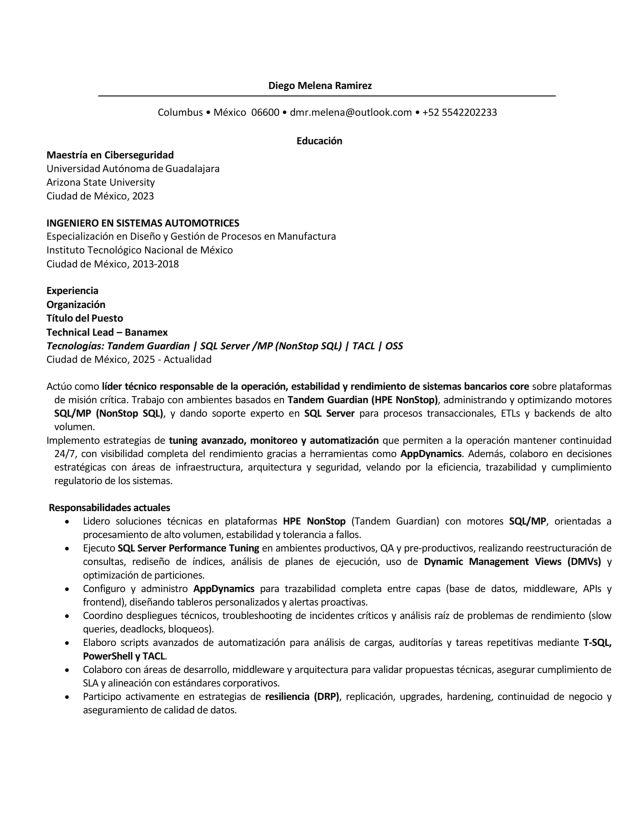

In [159]:
import os
import io
import PyPDF2
import matplotlib.pyplot as plt
from pdf2image import convert_from_bytes

POPPLER_PATH = (
    r"C:\ProgramData\chocolatey\lib\poppler-24.08.0\Library\bin"
)
# 1) locate the first PDF
resumes_dir = os.path.join(os.getcwd(), "resumes")
files = os.listdir(resumes_dir)
pdf_files = [f for f in files if f.lower().endswith(".pdf")]

if not pdf_files:
    raise RuntimeError("No PDF found in resumes/")

first_pdf = pdf_files[CV_NUMBER]
file_path = os.path.join(resumes_dir, first_pdf)
print(f"Loading {first_pdf!r}")

# 2) read its bytes and load into PyPDF2
with open(file_path, "rb") as f:
    pdf_bytes = f.read()

pdf_reader = PyPDF2.PdfReader(io.BytesIO(pdf_bytes))
print(f"→ {len(pdf_reader.pages)} pages")

# 3) convert only page 1 to a PIL.Image
images = convert_from_bytes(
    pdf_bytes,
    dpi=450,
    first_page=1,
    last_page=1,
    poppler_path=POPPLER_PATH
)
img = images[0]  # PIL.Image

# 4) display inline in Jupyter
plt.figure(figsize=(8, 11))
plt.imshow(img)
plt.axis("off")
plt.show()

Work in a single file

Found 13 sections:
  col 0, row 0: start=(0,0), width=114px, height=2475px
  col 0, row 1: start=(0,2475), width=114px, height=2475px
  col 1, row 0: start=(114,0), width=3653px, height=224px
  col 1, row 1: start=(114,224), width=3653px, height=351px
  col 1, row 2: start=(114,575), width=3653px, height=149px
  col 1, row 3: start=(114,724), width=3653px, height=512px
  col 1, row 4: start=(114,1236), width=3653px, height=417px
  col 1, row 5: start=(114,1653), width=3653px, height=588px
  col 1, row 6: start=(114,2241), width=3653px, height=748px
  col 1, row 7: start=(114,2989), width=3653px, height=1657px
  col 1, row 8: start=(114,4646), width=3653px, height=304px
  col 2, row 0: start=(3767,0), width=58px, height=2475px
  col 2, row 1: start=(3767,2475), width=58px, height=2475px


(np.float64(-0.5), np.float64(3824.5), np.float64(4949.5), np.float64(-0.5))

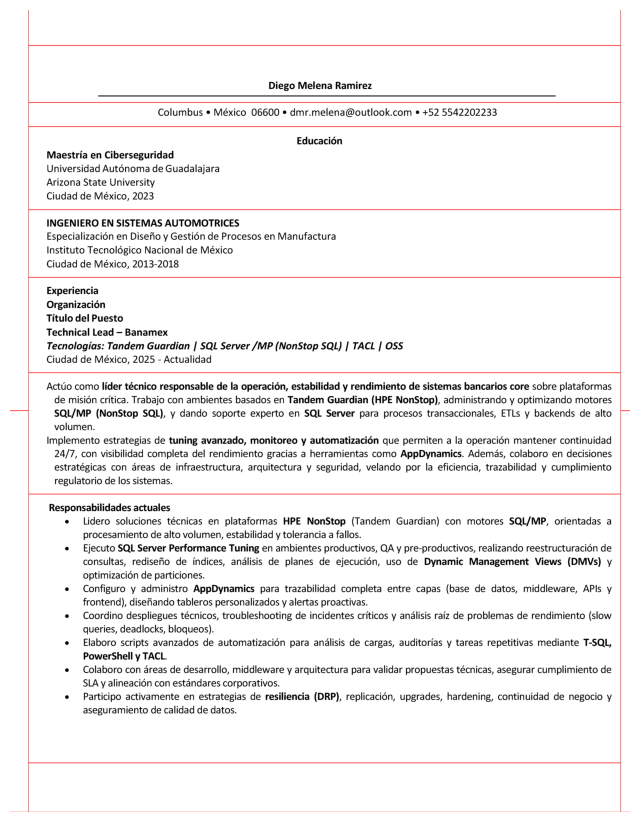

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# assume `img` is your original PIL page‐image

# --- 0) PREPROCESSING: grayscale → binarize so text is black, background white ---
gray_arr = np.array(img.convert("L"))
thresh = 128
# ink mask: True where text (dark)
ink = gray_arr < thresh
# build a display image: 0=black text, 255=white bg
bin_arr = np.where(ink, 0, 255).astype("uint8")
# replace img with the binarized version (RGB so we can draw red lines)
img = Image.fromarray(bin_arr, mode="L").convert("RGB")

# now `ink` is the same mask you’ll use below, and `img` is pure b/w for drawing
w, h = img.size

# 1) binary ink mask
# (we already have `ink` from above, so you can drop the old gray<250 line)

# 2) detect vertical splits
col_sums = ink.sum(axis=0)
min_v_gap = 50
v_thresh = h * 0.01
v_splits = []
x = 0
while x < w:
    if col_sums[x] < v_thresh:
        start = x
        while x < w and col_sums[x] < v_thresh:
            x += 1
        end = x
        if (end - start) >= min_v_gap:
            v_splits.append((start + end)//2)
    else:
        x += 1

# 3) define column dividers
x_divs = [0] + v_splits + [w]

# 4) find horizontal splits per column
min_h_gap = 50
h_splits_by_col = []
for x0, x1 in zip(x_divs[:-1], x_divs[1:]):
    sub = ink[:, x0:x1]
    row_sums = sub.sum(axis=1)
    h_thresh = (x1 - x0) * 0.01

    ys = []
    y = 0
    while y < h:
        if row_sums[y] < h_thresh:
            start = y
            while y < h and row_sums[y] < h_thresh:
                y += 1
            end = y
            if (end - start) >= min_h_gap:
                ys.append((start + end)//2)
        else:
            y += 1

    h_splits_by_col.append(ys)

# 5) draw the splits and collect rect info
out = img.copy()
draw = ImageDraw.Draw(out)
for x in v_splits:
    draw.line([(x, 0), (x, h)], fill="red", width=3)

sections = []
for ci, (x0, x1) in enumerate(zip(x_divs[:-1], x_divs[1:])):
    y_divs = [0] + h_splits_by_col[ci] + [h]
    for ri, (y0, y1) in enumerate(zip(y_divs[:-1], y_divs[1:])):
        draw.line([(x0, y1), (x1, y1)], fill="red", width=4)
        width = x1 - x0
        height = y1 - y0
        sections.append((ci, ri, x0, y0, width, height))

# 6) print each section’s top-left and size
print(f"Found {len(sections)} sections:")
for ci, ri, x0, y0, w0, h0 in sections:
    print(f"  col {ci}, row {ri}: start=({x0},{y0}), "
          f"width={w0}px, height={h0}px")
   
# 7) display the image
plt.figure(figsize=(8, 11))
plt.imshow(out)
plt.axis("off")

For each sections we can apply OCR algorithm

Text(0.5, 1.0, 'Full page with selected section highlighted')

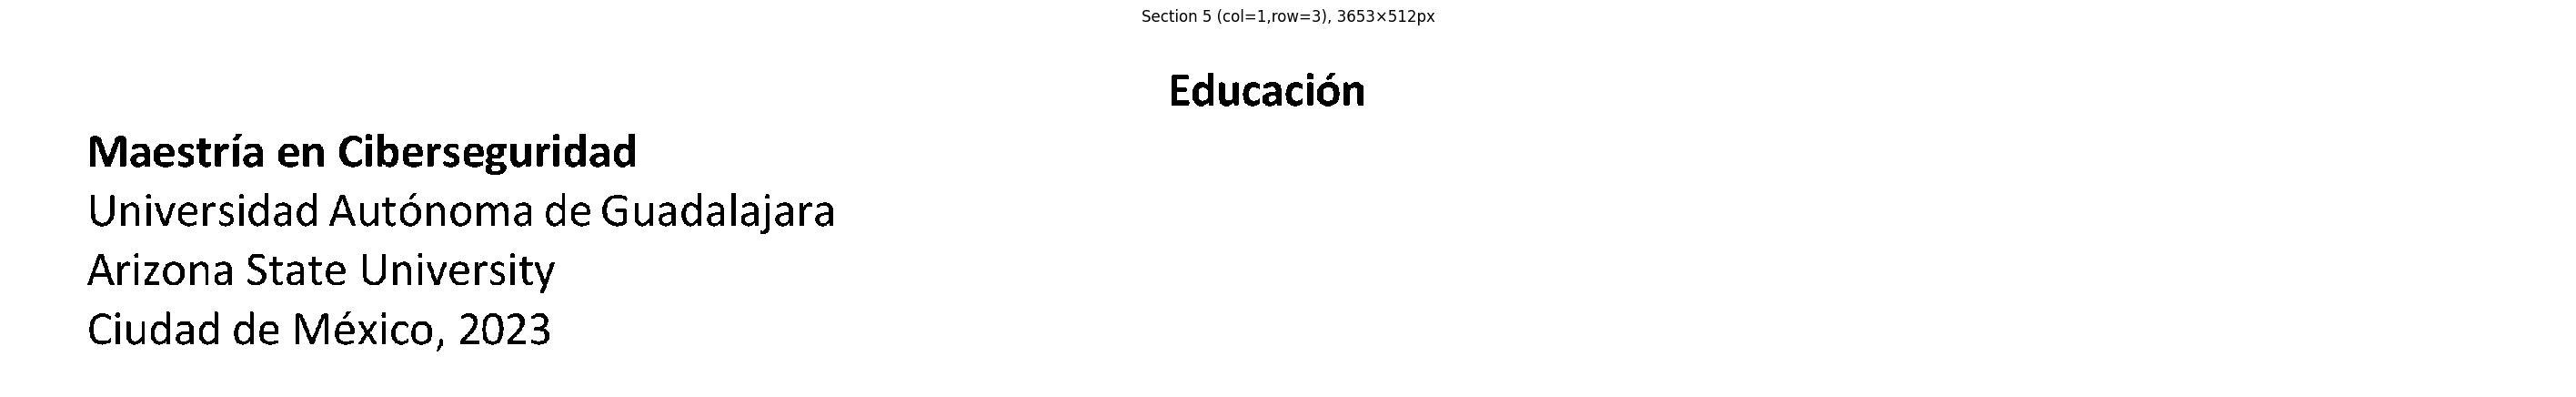

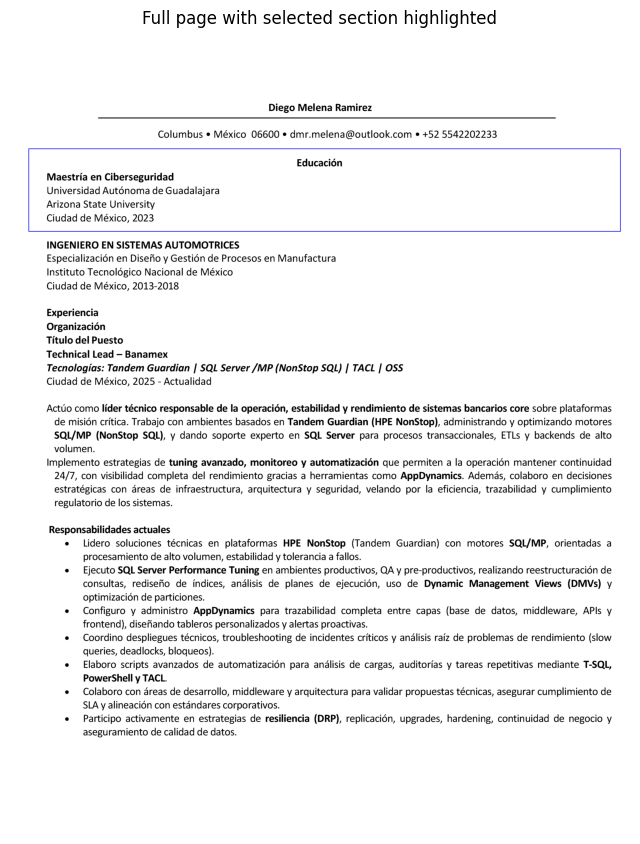

In [161]:
from PIL import ImageDraw
import matplotlib.pyplot as plt

# 1) Build a list of all section images
section_imgs = []
for idx, (ci, ri, x0, y0, w0, h0) in enumerate(sections):
    sec = img.crop((x0, y0, x0 + w0, y0 + h0))
    section_imgs.append(sec)

# 3) Choose which one to display
section_idx = SHOWCASE_SECTION
ci, ri, x0, y0, w0, h0 = sections[section_idx]

# 4) Grab it from the array
sec_img = section_imgs[section_idx]

# 5) Display at full (native) resolution
dpi = plt.rcParams['figure.dpi']
figsize = (w0 / dpi, h0 / dpi)
plt.figure(figsize=figsize, dpi=dpi)
plt.imshow(sec_img, interpolation='nearest')
plt.axis('off')
plt.title(f"Section {section_idx} "
          f"(col={ci},row={ri}), {w0}×{h0}px")

# 6) (Optional) Show full page with that region highlighted
out2 = img.copy()
draw2 = ImageDraw.Draw(out2)
draw2.rectangle(
    [(x0, y0), (x0 + w0, y0 + h0)],
    outline="blue",
    width=4
)
plt.figure(figsize=(8, 11))
plt.imshow(out2)
plt.axis("off")
plt.title("Full page with selected section highlighted")

Por cada sección se va a extraer el texto a travez de Tesseract 

In [162]:
# Array de imágenes PIL.Image.Image
import pytesseract

pytesseract.pytesseract.tesseract_cmd = (
    r"C:\Program Files\Tesseract-OCR\tesseract.exe"
)

# Filtrar section_imgs para quedarnos solo con las que tienen texto
filtered = []
for sec in section_imgs:
    text = pytesseract.image_to_string(sec, lang="eng+spa")
    if text.strip():
        filtered.append((sec, text))

# Sobrescribimos section_imgs con sólo las imágenes no vacías
section_imgs = [sec for sec, _ in filtered]
text_sections = [txt for _, txt in filtered]

# Imprimir índice y primeros 50 caracteres de cada texto detectado
for i, text in enumerate(text_sections):
    snippet = text.strip().replace("\n", " ")
    print(f"{i}: {snippet}")

0: Diego Melena Ramirez
1: Columbus ¢ México 06600 ¢ dmr.melena@outlook.com ¢ +52 5542202233
2: Educacion Maestria en Ciberseguridad Universidad Autonoma de Guadalajara Arizona State University Ciudad de México, 2023
3: INGENIERO EN SISTEMAS AUTOMOTRICES  Especializaci6n en Disefo y Gestion de Procesos en Manufactura Instituto Tecnoldgico Nacional de México  Ciudad de México, 2013-2018
4: Experiencia  Organizacion  Titulo del Puesto  Technical Lead — Banamex  Tecnologias: Tandem Guardian | SQL Server /MP (NonStop SQL) | TACL | OSS Ciudad de México, 2025 - Actualidad
5: Actuo como lider técnico responsable de la operacion, estabilidad y rendimiento de sistemas bancarios core sobre plataformas de mision critica. Trabajo con ambientes basados en Tandem Guardian (HPE NonStop), administrando y optimizando motores SQL/MP (NonStop SQL), y dando soporte experto en SQL Server para procesos transaccionales, ETLs y backends de alto volumen.  Implemento estrategias de tuning avanzado, monitoreo y 

El texto es extraido perfectamente. Despues de esto podemos revisar img por img que sea correcto.

In [166]:
# 2) Define a function to display one filtered section alongside its OCR snippet
def show_section(idx):
    """
    Display the idx-th filtered section image side-by-side with
    its OCR snippet.
    """
    sec_img, text = filtered[idx]
    # Prepare the snippet (first 200 chars, single line)
    snippet = text.strip().replace("\n", " ")
    print(snippet)
    # Compute figure size: width = image_width + text_space, height = image_height
    w, h = sec_img.size
    dpi = plt.rcParams['figure.dpi']
    # Give ~2 inches extra width for the text panel
    figsize = ((w / dpi) + 2, h / dpi)
    
    # Create side-by-side axes
    fig, (ax_img, ax_txt) = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
    
    # Left: the cropped image
    ax_img.imshow(sec_img)
    ax_img.axis('off')
    
    # Right: the text snippet
    ax_txt.axis('off')
    plt.tight_layout()
    plt.show()


# Optional, feel free to select a range of sections to read.
# for i in range(len(filtered)):
#     show_section(i)

Reto: Con el array de text_sections. Es posible llenar la estructura de datos usando NTLK? 

In [ ]:
import re
import json
# Regex patterns
_EMAIL_RE = re.compile(r"[a-zA-Z0-9.+_-]+@[a-zA-Z0-9._-]+\.[a-zA-Z]+")
_PHONE_RE = re.compile(r"(?:\+\d{1,3}\s*)?\d{7,15}")
_URL_RE   = re.compile(r"https?://[^\s]+|www\.[^\s]+")

def extract_email(text: str) -> Optional[str]:
    """Return the first email found in text, or None."""
    m = _EMAIL_RE.search(text)
    return m.group(0) if m else None

def extract_phone(text: str) -> Optional[str]:
    """Return the first phone number found in text, or None."""
    m = _PHONE_RE.search(text)
    return m.group(0) if m else None

def extract_urls(text: str) -> List[str]:
    """Return all URLs found in text (may be empty)."""
    return _URL_RE.findall(text) or []

email_list = list(dict.fromkeys(
    e
    for txt in text_sections
    if (e := extract_email(txt)) is not None
))

phone_list = list(dict.fromkeys(
    p
    for txt in text_sections
    if (p := extract_phone(txt)) is not None
))

url_list = list(dict.fromkeys(
    u
    for txt in text_sections
    for u in extract_urls(txt)
))
text_sections = [text.replace("\n", " ") for text in text_sections]

print(json.dumps(text_sections, indent=2, ensure_ascii=False))
# Build the resume
resume = Resume()
resume.email      = email_list[0] if email_list else None
resume.phone      = phone_list[0] if phone_list else None
resume.hyperlinks = url_list

print(resume)

[
  "Diego Melena Ramirez ",
  "Columbus ¢ México 06600 ¢ dmr.melena@outlook.com ¢ +52 5542202233 ",
  "Educacion Maestria en Ciberseguridad Universidad Autonoma de Guadalajara Arizona State University Ciudad de México, 2023 ",
  "INGENIERO EN SISTEMAS AUTOMOTRICES  Especializaci6n en Disefo y Gestion de Procesos en Manufactura Instituto Tecnoldgico Nacional de México  Ciudad de México, 2013-2018 ",
  "Experiencia  Organizacion  Titulo del Puesto  Technical Lead — Banamex  Tecnologias: Tandem Guardian | SQL Server /MP (NonStop SQL) | TACL | OSS Ciudad de México, 2025 - Actualidad ",
  "Actuo como lider técnico responsable de la operacion, estabilidad y rendimiento de sistemas bancarios core sobre plataformas de mision critica. Trabajo con ambientes basados en Tandem Guardian (HPE NonStop), administrando y optimizando motores SQL/MP (NonStop SQL), y dando soporte experto en SQL Server para procesos transaccionales, ETLs y backends de alto volumen.  Implemento estrategias de tuning avanz